# Install & imports 

In [1]:
#General
import pandas as pd
import numpy as np
import json

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
import xgboost as xgb
import lightgbm as lgb
import torch

# Geolocation
from geopy.geocoders import Nominatim

# Compressed serialization
from joblib import dump, load

# Options
pd.set_option('display.max_columns', 100)


In [2]:
DATA_DIR = "predict-energy-behavior-of-prosumers/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client = pd.read_csv(DATA_DIR + "client.csv")
historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas = pd.read_csv(DATA_DIR + "gas_prices.csv")

In [3]:
DEBUG = False 

In [4]:
# GPU or CPU use for model
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
# Helper functions
def display_df(df, name):
    '''Display df shape and first 5 rows '''
    print(f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns.') # shape[0]: row, shape[1]: column
    display(df.head(5))

In [6]:
display_df(train, 'train')
display_df(client, 'client')
display_df(historical_weather, 'historical weather')
display_df(forecast_weather, 'forecast weather')
display_df(electricity, 'electricity prices')
display_df(gas, 'gas prices')
# display_df(location, 'location data')

train data has 2018352 rows and 9 columns.


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


client data has 41919 rows and 7 columns.


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


historical weather data has 1710802 rows and 18 columns.


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


forecast weather data has 3424512 rows and 18 columns.


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


electricity prices data has 15286 rows and 4 columns.


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


gas prices data has 637 rows and 5 columns.


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [7]:
# See county codes
with open(DATA_DIR + 'county_id_to_name_map.json') as f:
    county_codes = json.load(f)
pd.DataFrame(county_codes, index=[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,HARJUMAA,HIIUMAA,IDA-VIRUMAA,JÄRVAMAA,JÕGEVAMAA,LÄÄNE-VIRUMAA,LÄÄNEMAA,PÄRNUMAA,PÕLVAMAA,RAPLAMAA,SAAREMAA,TARTUMAA,UNKNOWN,VALGAMAA,VILJANDIMAA,VÕRUMAA


In [8]:
pd.DataFrame(
    train[train['is_consumption'] == 0]
    .target.describe(
        percentiles=[0, 0.001, 0.01, 0.05, 0.1,
                     0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
    )
).round(2).T

,count,mean,std,min,0%,0.1%,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
target,1008912.0,89.0,384.49,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.39,24.1,191.82,434.9,1479.99,5442.66,11255.66


In [9]:
pd.DataFrame(train[train['is_consumption'] == 1].target.describe(percentiles=[
             0, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])).round(2).T

,count,mean,std,min,0%,0.1%,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
target,1008912.0,460.71,1198.95,0.0,0.0,0.28,1.86,6.42,12.0,34.51,108.9,386.97,972.05,1567.52,7141.02,12369.16,15480.27


# Data processing

In [10]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude 經緯度
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 聚合統計函數
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost) 指定了哪些列是分類型列
        # 使用XGBoost等機器學習算法時非常重要，因為這些算法需要知道哪些列是分類型數據
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''Create features for main data (test or train) set'''
        # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])
        
        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week
        data['hour'] = data['datetime'].dt.hour
        
        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month']  = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week
        return data

    def create_client_features(self, client):
        '''Create client features'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''Create historical weather features'''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
    
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''Create forecast weather features'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = pd.to_datetime(forecast_weather['datetime']).dt.tz_localize('UTC')
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_convert('Europe/Brussels')
        forecast_weather['datetime'] = forecast_weather['datetime'].dt.tz_localize(None)



        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''Create electricity prices features'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        ''' Create gas prices features'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # Merge all datasets into one df
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df

In [11]:
# 在時間序列數據集中為"每個觀測"添加過去特定天數的目標值
# 這種方法在時間序列分析或預測任務中很常見，尤其是當預測的目標值依賴於過去的值時
# data（原始數據集）和 N_day_lags（要創建的天數滯後數）

def create_revealed_targets_train(data, N_day_lags):
    '''Create past revealed_targets for train set based on number of day lags N_day_lags'''    
    original_datetime = data['datetime']
    revealed_targets = data[['datetime', 'prediction_unit_id', 'is_consumption', 'target']].copy() # 新的 DataFrame 框架
    
    # Create revealed targets for all day lags
    # 通過迴圈，從 2 天滯後開始，直到 N_day_lags（包含）
    for day_lag in range(2, N_day_lags+1):
        revealed_targets['datetime'] = original_datetime + pd.DateOffset(day_lag)
        # 使用 merge 函數將更新後的 revealed_targets 與原始數據集合併，基於 datetime、prediction_unit_id 和 is_consumption 列
        data = data.merge(revealed_targets, 
                          how='left', 
                          on = ['datetime', 'prediction_unit_id', 'is_consumption'],
                          suffixes = ('', f'_{day_lag}_days_ago') # 合併後的列添加後綴
                         )
    return data

In [12]:
# 用於測量並顯示整個單元格執行所需的時間
# (Jupyter Notebook的魔法命令?)
# %%time
# Create all features
# 表示在特徵工程中將考慮過去15天的數據
N_day_lags = 15  # Specify how many days we want to go back (at least 2)

FeatureProcessor = FeatureProcessorClass()

data = FeatureProcessor(data=train.copy(),
                        client=client.copy(),
                        historical_weather=historical_weather.copy(),
                        forecast_weather=forecast_weather.copy(),
                        electricity=electricity.copy(),
                        gas=gas.copy(),
                        )

df = create_revealed_targets_train(data.copy(),
                                   N_day_lags=N_day_lags)

In [13]:
df

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,date,year,quarter,month,week,hour,day_of_year,day_of_month,day_of_week,eic_count_client,installed_capacity_client,date_client,temperature_h_mean,dewpoint_h_mean,rain_h_mean,snowfall_h_mean,surface_pressure_h_mean,cloudcover_total_h_mean,cloudcover_low_h_mean,cloudcover_mid_h_mean,cloudcover_high_h_mean,windspeed_10m_h_mean,winddirection_10m_h_mean,shortwave_radiation_h_mean,direct_solar_radiation_h_mean,diffuse_radiation_h_mean,hour_h,hours_ahead_f_mean,temperature_f_mean,dewpoint_f_mean,cloudcover_high_f_mean,cloudcover_low_f_mean,cloudcover_mid_f_mean,cloudcover_total_f_mean,10_metre_u_wind_component_f_mean,10_metre_v_wind_component_f_mean,direct_solar_radiation_f_mean,surface_solar_radiation_downwards_f_mean,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electricity,euros_per_mwh_electricity,origin_date_electricity,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas,target_2_days_ago,target_3_days_ago,target_4_days_ago,target_5_days_ago,target_6_days_ago,target_7_days_ago,target_8_days_ago,target_9_days_ago,target_10_days_ago,target_11_days_ago,target_12_days_ago,target_13_days_ago,target_14_days_ago,target_15_days_ago
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021-09-01,2021,3,9,35,0,244,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,2023-05-31 23:00:00,637,2018347,64,2023-05-31,2023,2,5,22,23,151,31,2,15.0,620.0,2023-05-29,9.902679,3.561607,0.0,0.00375,1013.811607,47.330357,1.517857,53.732143,47.008929,2.583085,247.794643,0.0,0.0,0.0,23.0,43.0,12.509339,6.159097,0.31376,0.042512,0.046971,0.39003,4.355891,-1.750496,143.064762,29.155556,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,188.167,173.048,184.072,188.122,356.783,415.530,182.342,459.845,162.786,186.582,191.756,181.415,421.707,410.259
2018348,15,1,1,0.000,0,2023-05-31 23:00:00,637,2018348,59,2023-05-31,2023,2,5,22,23,151,31,2,20.0,624.5,2023-05-29,9.902679,3.561607,0.0,0.00375,1013.811607,47.330357,1.517857,53.732143,47.008929,2.583085,247.794643,0.0,0.0,0.0,23.0,43.0,12.509339,6.159097,0.31376,0.042512,0.046971,0.39003,4.355891,-1.750496,143.064762,29.155556,0.0,0.0,2023-05-30 23:00:00,-1.29,2023-05-29 23:00:00,2023-05-30,29.0,34.0,2023-05-29,31.5,0.000,0

# XGBoost single fold

In [14]:
#### Create single fold split ######
target = 'target'
df = df[df[target].notnull()].reset_index(drop=True) # Remove empty target row

train_block_id = list(range(0, 600)) 

tr = df[df['data_block_id'].isin(train_block_id)] # first 600 data_block_ids used for training
val = df[~df['data_block_id'].isin(train_block_id)] # rest data_block_ids used for validation

In [15]:
# Remove columns for features
no_features = ['date', 
                'latitude', 
                'longitude', 
                'data_block_id', 
                'row_id',
                'hours_ahead',
                'hour_h',
               ]

remove_columns = [col for col in df.columns for no_feature in no_features if no_feature in col]
remove_columns.append(target)
features = [col for col in df.columns if col not in remove_columns]
print(f'There are {len(features)} features: {features}')

There are 59 features: ['county', 'is_business', 'product_type', 'is_consumption', 'prediction_unit_id', 'year', 'quarter', 'month', 'week', 'hour', 'day_of_year', 'day_of_month', 'day_of_week', 'eic_count_client', 'installed_capacity_client', 'temperature_h_mean', 'dewpoint_h_mean', 'rain_h_mean', 'snowfall_h_mean', 'surface_pressure_h_mean', 'cloudcover_total_h_mean', 'cloudcover_low_h_mean', 'cloudcover_mid_h_mean', 'cloudcover_high_h_mean', 'windspeed_10m_h_mean', 'winddirection_10m_h_mean', 'shortwave_radiation_h_mean', 'direct_solar_radiation_h_mean', 'diffuse_radiation_h_mean', 'temperature_f_mean', 'dewpoint_f_mean', 'cloudcover_high_f_mean', 'cloudcover_low_f_mean', 'cloudcover_mid_f_mean', 'cloudcover_total_f_mean', '10_metre_u_wind_component_f_mean', '10_metre_v_wind_component_f_mean', 'direct_solar_radiation_f_mean', 'surface_solar_radiation_downwards_f_mean', 'snowfall_f_mean', 'total_precipitation_f_mean', 'euros_per_mwh_electricity', 'lowest_price_per_mwh_gas', 'highest_

In [16]:
clf = xgb.XGBRegressor(
                        device = device,
                        enable_categorical=True,
                        objective = 'reg:absoluteerror',
                        n_estimators = 2 if DEBUG else 1500,
                        early_stopping_rounds=100
                       )

In [17]:
clf.fit(X = tr[features], 
        y = tr[target], 
        eval_set = [(tr[features], tr[target]), (val[features], val[target])], # 用於提供一個或多個（特徵，目標）對，以便在訓練過程中評估模型的性能
        verbose=True #用於控制訓練過程中的信息輸出
       )

dump(clf, 'model.joblib')

[0]	validation_0-mae:241.33152	validation_1-mae:313.33988
[1]	validation_0-mae:215.62080	validation_1-mae:281.05339
[2]	validation_0-mae:189.75736	validation_1-mae:248.11791
[3]	validation_0-mae:169.86443	validation_1-mae:223.35838
[4]	validation_0-mae:153.69272	validation_1-mae:205.12707
[5]	validation_0-mae:139.56570	validation_1-mae:189.52772
[6]	validation_0-mae:122.12598	validation_1-mae:170.03529
[7]	validation_0-mae:102.53419	validation_1-mae:147.50098
[8]	validation_0-mae:88.15189	validation_1-mae:128.18834
[9]	validation_0-mae:78.86376	validation_1-mae:118.21390
[10]	validation_0-mae:71.55262	validation_1-mae:110.49772
[11]	validation_0-mae:67.01246	validation_1-mae:105.69297
[12]	validation_0-mae:63.14198	validation_1-mae:103.07386
[13]	validation_0-mae:60.70913	validation_1-mae:101.18482
[14]	validation_0-mae:59.01029	validation_1-mae:99.93775
[15]	validation_0-mae:58.15727	validation_1-mae:98.80108
[16]	validation_0-mae:57.50822	validation_1-mae:98.48774
[17]	validation_0-m

['model.joblib']

In [18]:
loaded_model = load('model.joblib')
print(f'Early stopping on best iteration #{loaded_model.best_iteration} with MAE error on validation set of {loaded_model.best_score:.2f}')

Early stopping on best iteration #384 with MAE error on validation set of 79.61


{'validation_0': OrderedDict([('mae', [241.3315233831262, 215.6207967585378, 189.75736295738304, 169.86442720592828, 153.69272106985264, 139.5657006928535, 122.12598226721396, 102.5341947362545, 88.15188854650722, 78.86376492619641, 71.55261860520936, 67.01245744720443, 63.14197570737647, 60.70913052808798, 59.01029077256268, 58.15726765008932, 57.50822156888961, 57.28956787420654, 57.24345567033294, 56.77478968576038, 56.600621658644776, 56.49336336157338, 55.879323555609375, 55.65219441034386, 55.622946592698305, 55.58429859734066, 55.380476362601, 55.062923409541, 55.02603814032276, 54.970459755815654, 54.94549954820725, 54.78483794522573, 54.72109964791728, 54.67537777847048, 54.49046418206899, 54.17892007178774, 53.46683551344669, 53.17969078348981, 53.1210956487825, 52.11496914829023, 51.782296965038874, 51.666100263336546, 51.63668011978044, 51.62320285852919, 50.77841720496787, 50.57915427659215, 50.487193852938404, 50.443766300709875, 50.41068190270649, 50.359987137604435, 50.

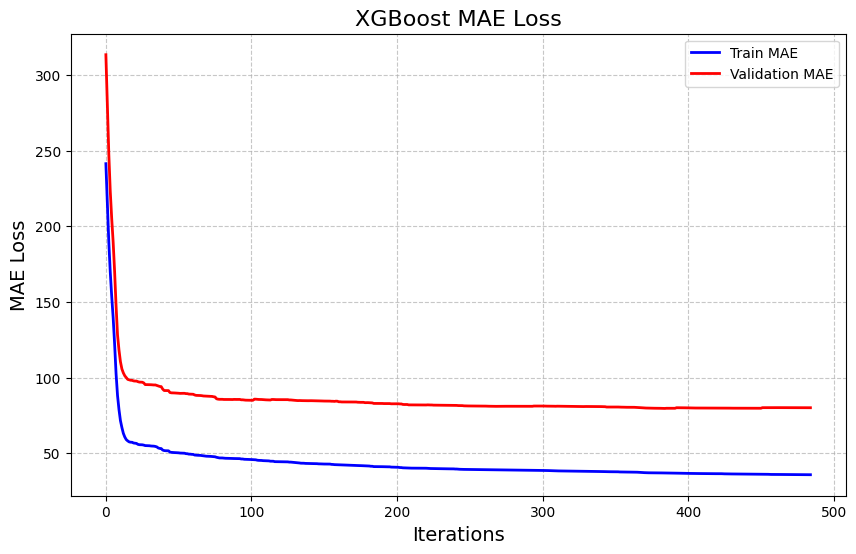

In [22]:
import matplotlib.pyplot as plt

results = clf.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
x_values = range(0, len(train_mae))

fig, ax = plt.subplots(figsize=(10, 6))  # 調整圖的大小

# 添加線條顏色和標籤
ax.plot(x_values, train_mae, label="Train MAE", color="b", linestyle="-", linewidth=2)
ax.plot(x_values, val_mae, label="Validation MAE", color="r", linestyle="-", linewidth=2)

# 添加網格線
ax.grid(True, linestyle='--', alpha=0.7)

# 調整標籤字體大小
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("MAE Loss", fontsize=14)
plt.title("XGBoost MAE Loss", fontsize=16)

# 調整圖例位置
ax.legend(loc="upper right")

# 顯示圖
plt.show()


/var/folders/p1/v78gy2fd7vjgcrn777cbypb00000gn/T/ipykernel_93423/870133849.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_data[:TOP], x='importance', y='name', palette=colors)


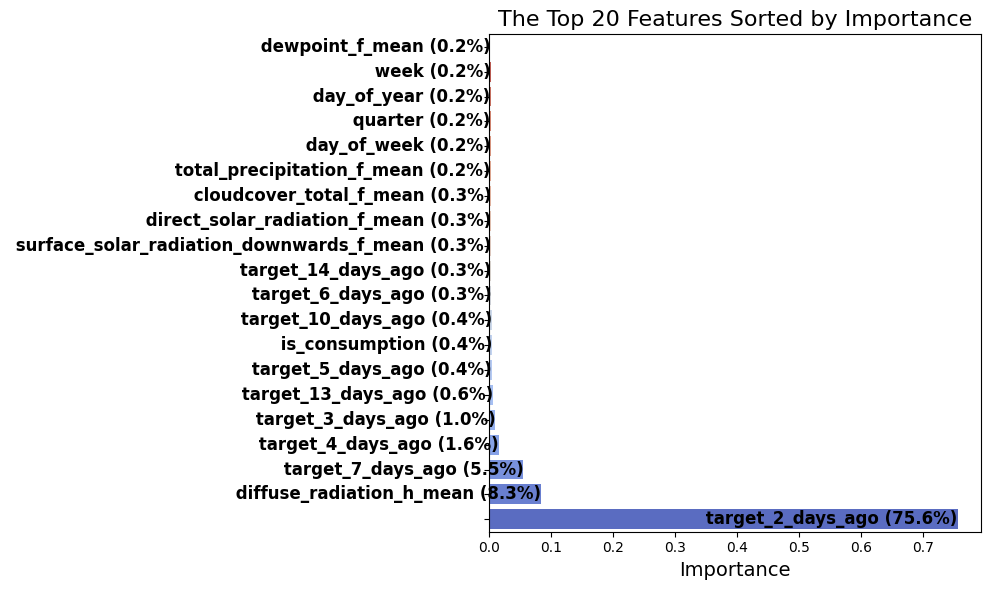

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

TOP = 20
importance_data = pd.DataFrame({'name': clf.feature_names_in_, 'importance': clf.feature_importances_})
importance_data = importance_data.sort_values(by='importance', ascending=False)

# Create a color palette
colors = sns.color_palette("coolwarm", len(importance_data[:TOP]))

# Create a barplot with annotations
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=importance_data[:TOP], x='importance', y='name', palette=colors)

# Add percentage labels without overlapping
for i, (value, name) in enumerate(zip(importance_data['importance'][:TOP], importance_data['name'][:TOP])):
    ax.text(value, i, f' {name} ({100*value:.1f}%)', ha='right', va='center', fontsize=12, color='black', weight='bold')

ax.set_yticklabels([])  # Hide y-axis labels
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.title(f'The Top {TOP} Features Sorted by Importance', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('', fontsize=14)  # Empty y-axis label
plt.tight_layout()  # Adjust layout to prevent overlapping

# Show the plot
plt.show()


In [21]:
importance_data[importance_data['importance']<0.0005].name.values

array(['cloudcover_total_h_mean', '10_metre_v_wind_component_f_mean',
       'cloudcover_high_f_mean', 'windspeed_10m_h_mean',
       'prediction_unit_id', 'rain_h_mean', 'snowfall_h_mean',
       'cloudcover_high_h_mean', 'cloudcover_mid_h_mean'], dtype=object)